In [1]:
#Import Library

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import math
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [2]:
# Import Dataset 

symbol='AAPL'
ticker= yf.Ticker(symbol)
df= ticker.history(start='2012-01-01', end='2019-12-17')
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-01-03 00:00:00-05:00,12.378496,12.472226,12.366401,12.433826,302220800,0.0,0.0
2012-01-04 00:00:00-05:00,12.396634,12.538138,12.374865,12.500645,260022000,0.0,0.0
2012-01-05 00:00:00-05:00,12.546301,12.655148,12.477362,12.639426,271269600,0.0,0.0
2012-01-06 00:00:00-05:00,12.692036,12.782138,12.675407,12.771556,318292800,0.0,0.0
2012-01-09 00:00:00-05:00,12.865291,12.933321,12.739812,12.751302,394024400,0.0,0.0


In [3]:
#Extracting only Close column from dataframe(df)

data= df.filter(['Close'])
dataset= data.values

In [4]:
#Scaling the data

training_data_len = math.ceil(len(dataset) *.8)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [5]:
#Prepare the Training data 

train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(60,len(train_data)):
     x_train.append(train_data[i-60:i, 0])
     y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)


In [6]:
#Reshape training data for LSTM Model

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [18]:
#Building LSTM Model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [8]:
#Compile the model

model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
#Train the model

model.fit(x_train, y_train, batch_size=1, epochs=1)

1542/1542 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - loss: 0.0017


In [10]:
#Prepare the Test Data

test_data = scaled_data[training_data_len - 60:,:]
x_test=[]
y_test = dataset[training_data_len:, :]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

x_test=np.array(x_test)
x_test= np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [11]:
#Get Predictions

predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step


In [12]:
#Calculate RMSE

rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('Root Mean Squared Error: ', rmse)

Root Mean Squared Error:  0.2580237865447998


C:\Users\Nasir\AppData\Local\Temp\ipykernel_11636\1910433358.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


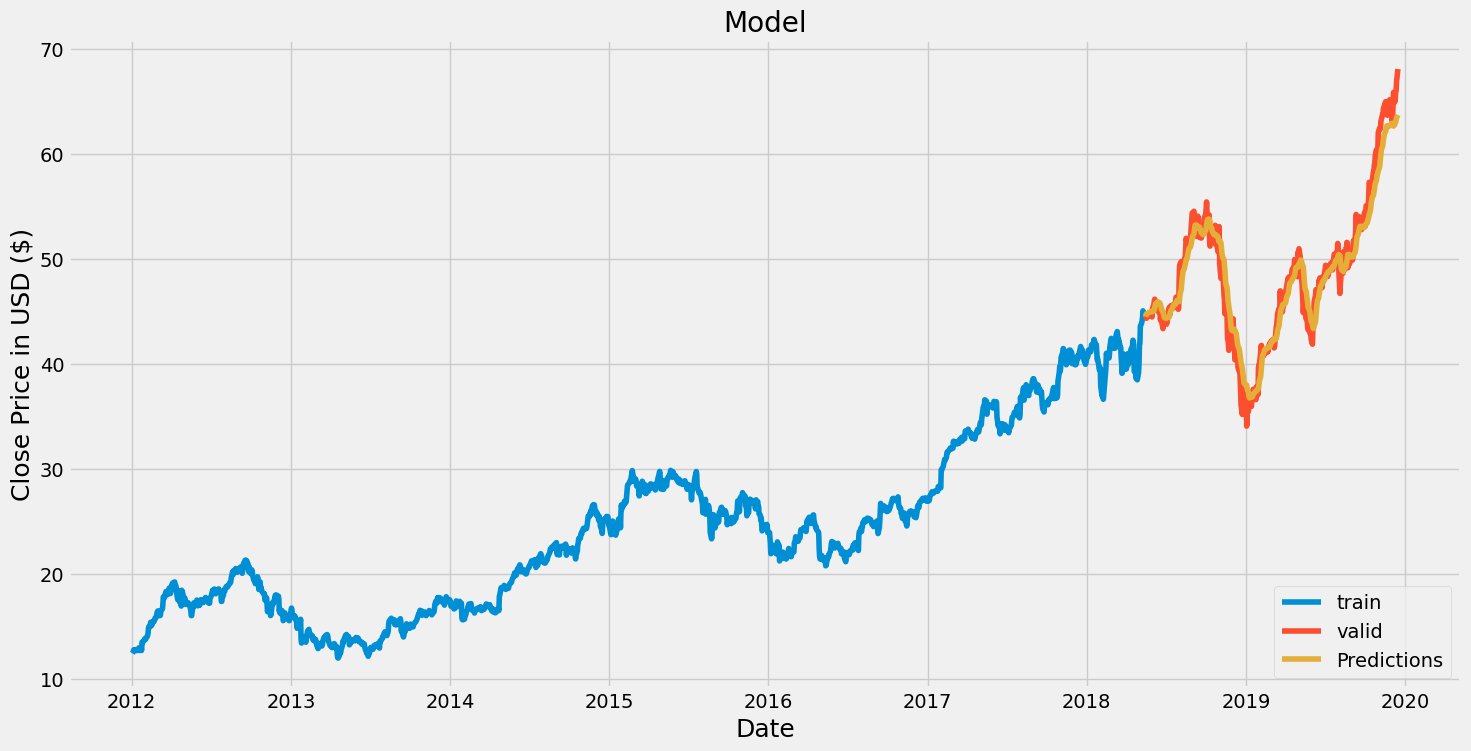

In [20]:
# Plot the data

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions


plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price in USD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['train','valid','Predictions'],loc='lower right')
plt.show()

In [14]:
#Actual vs Predicted value for 'Close' column

valid

,Close,Predictions
Date,,
2018-05-16 00:00:00-04:00,44.782890,44.484165
2018-05-17 00:00:00-04:00,44.499695,44.665001
2018-05-18 00:00:00-04:00,44.337887,44.769562
2018-05-21 00:00:00-04:00,44.652008,44.808479
2018-05-22 00:00:00-04:00,44.540161,44.843143
...,...,...
2019-12-10 00:00:00-05:00,65.307121,62.918743
2019-12-11 00:00:00-05:00,65.864151,63.056679
2019-12-12 00:00:00-05:00,66.031998,63.240326


In [15]:
#Get the dataset again(Taking one more day this time)

new_data=yf.Ticker('AAPL').history(start='2012-01-01', end='2019-12-18').filter(['Close']).values


#Get the last 60 days closing price values 

last_60_days = new_data[-60:,:]
last_60_days_scaled = scaler.fit_transform(last_60_days)

#Create an empty list and get the predicted value

x_test=[]
x_test.append(last_60_days_scaled)
x_test=np.array(x_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
pred_price=model.predict(x_test)
predicted_price=scaler.inverse_transform(pred_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [16]:
predicted_price

array([[66.05557]], dtype=float32)